<a href="https://colab.research.google.com/github/anthonymelson/portfolio/blob/master/ITS_with_Sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Generate Time Series Data with Slope Change, Level Change, and noise

In [2]:
## Generate ITS Data
dummy = np.asarray([0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0])
t = np.linspace(0,14,29)
alpha = 15
slope1 = 3
level = 50
slope2 = 0
sigma = np.random.normal(0,5,len(t))
y = alpha + slope1 * t + slope2*t*dummy + level*dummy + sigma

## Create df with Columns for Time, Treatment, and Interaction

Time captures universal change of ts.  Treatment (1 or 0) captures level change.  Interaction captures slope change/difference.

Goal: use linear regression to asertain the significance of these three variables on the outcome.  If one, say treatment, is significant, it can be said that the treatment had an effect and the effect sized can be estimated by taking the difference between the actual values and a prediction of the treatment period using the data before ( and in this case) after the treatment.

In [3]:
## Create Array that contains 3 columns: a time column, a treatment column, and an interaction column, which pair with the slope1, level, and slope2 coefficients
x = pd.DataFrame(np.array([
                           [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14,15,16,17,18,19,20,21,22,23,24,25,26,27,28],
                           [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0]], dtype=float).T,columns=['time','treatment'])
x['interaction'] = x['time'] * x['treatment']

### Get actual treatment effect

In [4]:
sum(x['treatment'] * level)

450.0

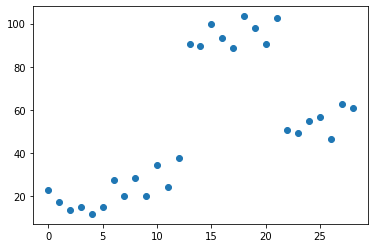

In [6]:
## View Data
plt.scatter(x['time'], y)

### Estimate counterfactual for treatment timeframe

What would have happened without a treatment.

In [7]:
# Create Counterfacutal
X2 = sm.add_constant(x)
counterfactual = sm.OLS(y[0:12], X2[0:12]).fit()
print(counterfactual.summary2())

                Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.282  
Dependent Variable: y                AIC:                78.2619
Date:               2021-08-18 21:52 BIC:                79.2317
No. Observations:   12               Log-Likelihood:     -37.131
Df Model:           1                F-statistic:        5.321  
Df Residuals:       10               Prob (F-statistic): 0.0438 
R-squared:          0.347            Scale:              34.224 
-----------------------------------------------------------------
                Coef.   Std.Err.    t     P>|t|   [0.025   0.975]
-----------------------------------------------------------------
const          14.5420    3.1768  4.5776  0.0010  7.4638  21.6203
time            1.1284    0.4892  2.3066  0.0438  0.0384   2.2185
treatment       0.0000    0.0000     nan     nan  0.0000   0.0000
interaction     0.0000    0.0000     nan     nan  0.0000   0.0000
-----------------------------------

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


### Run model with treatment included as variable

Determine significance of intervention.

In [8]:
X3 = sm.add_constant(x)
segmented_regression = sm.OLS(y, X3).fit()
print(segmented_regression.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.971   
Dependent Variable: y                AIC:                185.3569
Date:               2021-08-18 21:52 BIC:                190.8261
No. Observations:   29               Log-Likelihood:     -88.678 
Df Model:           3                F-statistic:        313.7   
Df Residuals:       25               Prob (F-statistic): 5.88e-20
R-squared:          0.974            Scale:              30.763  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
const         12.1233    2.0483   5.9188  0.0000   7.9049  16.3418
time           1.6827    0.1289  13.0580  0.0000   1.4173   1.9481
treatment     65.8452   12.4814   5.2755  0.0000  40.1392  91.5512
interaction   -0.6730    0.7275  -0.9251  0.3638  -2.1714   0.8254
--------------------

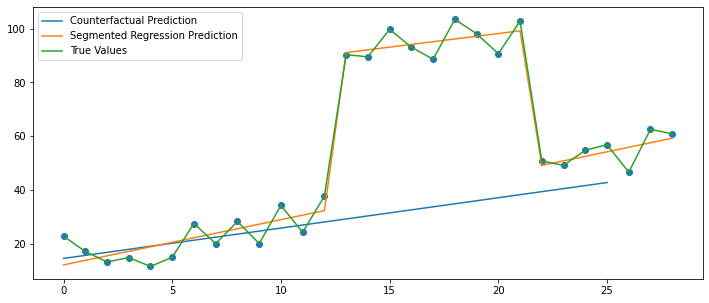

In [9]:
# Plot Counterfactual Prediction
plt.figure(figsize=(12,5))
plt.plot(counterfactual.predict(X2[0:26]))
plt.plot(segmented_regression.predict(X3))
plt.plot(y)
plt.legend(['Counterfactual Prediction', 'Segmented Regression Prediction', 'True Values'])
plt.scatter(x['time'],y)

### Compute lift

In [10]:
lift =  y - counterfactual.predict(X2[0:29]) 

552.666064698333

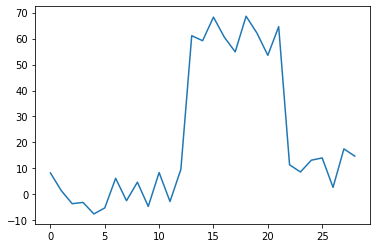

In [11]:
plt.plot(x['time'],lift)
(lift * x['treatment']).sum()

# Key Question about using prior and post intervention data for counterfactual

Can I simply eliminate the time values that correspond to the treatment and fit a model to the prior and post points with the remaining values?



## Create data with gap for model

In [12]:
x_counter, y_counter = x[x['treatment'] != 1], y[x['treatment'] != 1]

In [13]:
x_counter, y_counter

(    time  treatment  interaction
 0    0.0        0.0          0.0
 1    1.0        0.0          0.0
 2    2.0        0.0          0.0
 3    3.0        0.0          0.0
 4    4.0        0.0          0.0
 5    5.0        0.0          0.0
 6    6.0        0.0          0.0
 7    7.0        0.0          0.0
 8    8.0        0.0          0.0
 9    9.0        0.0          0.0
 10  10.0        0.0          0.0
 11  11.0        0.0          0.0
 12  12.0        0.0          0.0
 22  22.0        0.0          0.0
 23  23.0        0.0          0.0
 24  24.0        0.0          0.0
 25  25.0        0.0          0.0
 26  26.0        0.0          0.0
 27  27.0        0.0          0.0
 28  28.0        0.0          0.0,
 array([12.07912809, 22.08239214, 23.57439067, 13.49498384, 31.26809244,
        23.78174351, 20.98752976, 31.67615066, 25.5805965 , 36.51226514,
        33.44711039, 35.00096844, 31.00207712, 43.71645452, 46.47883356,
        53.42068397, 55.07672144, 53.24045057, 69.04638671, 57.476

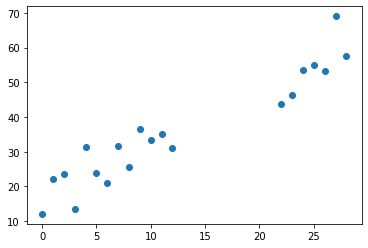

In [14]:
plt.scatter(x_counter['time'],y_counter)

In [15]:
# Create Counterfacutal
x_counter = sm.add_constant(x_counter)
counterfactual = sm.OLS(y_counter, x_counter).fit()
print(counterfactual.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.887   
Dependent Variable: y                AIC:                125.2134
Date:               2021-08-16 02:08 BIC:                127.2049
No. Observations:   20               Log-Likelihood:     -60.607 
Df Model:           1                F-statistic:        149.5   
Df Residuals:       18               Prob (F-statistic): 3.73e-10
R-squared:          0.893            Scale:              27.887  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
const         16.9702    1.9502   8.7019  0.0000  12.8730  21.0674
time           1.5002    0.1227  12.2270  0.0000   1.2424   1.7579
treatment      0.0000    0.0000      nan     nan   0.0000   0.0000
interaction    0.0000    0.0000      nan     nan   0.0000   0.0000
--------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


## Predict remaining values

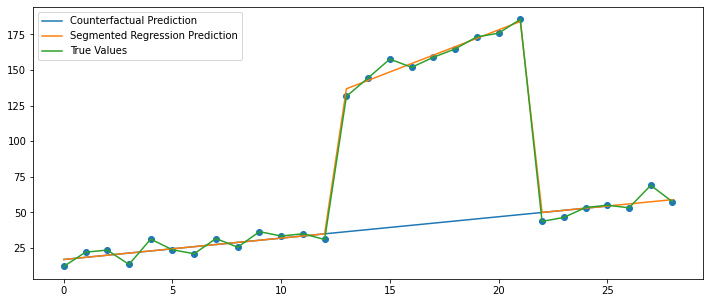

In [16]:
# Plot Counterfactual Prediction
plt.figure(figsize=(12,5))
plt.plot(counterfactual.predict(X2[0:26]))
plt.plot(segmented_regression.predict(X3))
plt.plot(y)
plt.legend(['Counterfactual Prediction', 'Segmented Regression Prediction', 'True Values'])
plt.scatter(x['time'],y)

## Much better results.

It appears to lead to more accurate counterfactual evaluations.  Lets test it numerically.

1061.5603340193163

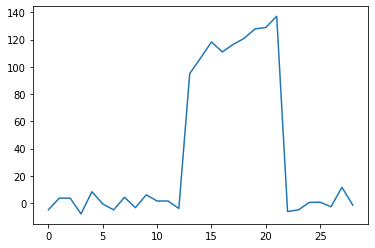

In [17]:
lift =  y - counterfactual.predict(X2[0:29]) 

plt.plot(x['time'],lift)
(lift * x['treatment']).sum()